In [ ]:
#@title Code to Import the required Libraries.
!pip install uniseg

import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import unicodedata
import re
import numpy as np
import os
import io
import time
import random
import shutil
from matplotlib.font_manager import FontProperties

# Imports for visualisations
from IPython.display import HTML as html_print
from IPython.display import display



In [ ]:
#@title Code to import wandb and login to wandb (Run this cell if you wish to use wandb)
!pip install wandb --upgrade
import wandb
!wandb login --relogin

# How to debug the code?

Reduce the number of word pairs being generated by create_dataset() to some small value say 100. However reduce the batch size to a value less than 100 else you may encounter [StopIteration() error](https://stackoverflow.com/questions/48709839/stopiteration-generator-output-nextoutput-generator).

Also, to reduce the validation datasize reduce the number of inputs in validate() to some small number like 10 instead of len(input_words). 

Run the train() for 1 epoch. To visualise the code for 20 epochs you can restore the model parameters as provided in the [github repository](https://github.com/utsavdey/cs6910_assignment3/blob/main/seq2seq_with_attention/training_checkpoints.zip) using `checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))` after runnning the train function for one epoch.

In [3]:
# Common Error: https://stackoverflow.com/questions/58352326/running-the-tensorflow-2-0-code-gives-valueerror-tf-function-decorated-functio
# https://pgaleone.eu/tensorflow/tf.function/2019/03/21/dissecting-tf-function-part-1/
tf.config.run_functions_eagerly(True)

# **NOTE:** 
The Hindi font file for displaying Hindi characters in the matplotlib plots [here](https://drive.google.com/file/d/11B4BahRBIujMr_jhsw_uXbxN9LF5CHaX/view?usp=sharing). A copy of the same has been upload in the GitHub project repository. *Kindly upload the same before generating the heatmaps.* 

In [ ]:
#@title Download Dataset and set file paths
# Download the dataset
!curl https://storage.googleapis.com/gresearch/dakshina/dakshina_dataset_v1.0.tar --output daksh.tar
# Extract the downloaded tar file
!tar -xvf  'daksh.tar'
# Set the file paths to train, validation and test dataset
train_file_path=os.path.join(os.getcwd(),"dakshina_dataset_v1.0","hi","lexicons","hi.translit.sampled.train.tsv")
vaildation_file_path = os.path.join(os.getcwd(),"dakshina_dataset_v1.0","hi","lexicons","hi.translit.sampled.dev.tsv")
test_file_path = os.path.join(os.getcwd(),"dakshina_dataset_v1.0","hi","lexicons","hi.translit.sampled.test.tsv")

In [5]:
#@title Data pre-processing and tokenisation 
def preprocess_word(w):
  w = '\t' + w + '\n'
  return w

# Returns pairs of target word,input word. E.g. [['\tअं\n', '\tan\n'], ['\tअंकगणित\n', '\tankganit\n']]
def create_dataset(path):
  lines = io.open(path, encoding='UTF-8').read().strip().split('\n')
  word_pairs = [[preprocess_word(w)  for w in line.split('\t')[:-1]]
                for line in lines[:-1]]
  return zip(*word_pairs)

def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='', char_level=True)
  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
  return tensor, lang_tokenizer

def load_dataset(path):
  targ_lang, inp_lang = create_dataset(path)

  input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
  target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

The above code segment is responsible for the below tasks:

*   Returns pairs of target word,input word: [HINDI, ENGLISH] as a list.
*   Every target word and input word is appended with a Start of Sequence Character '\t' and End of Sequence Character '\n'.
*   Finally, we make a dictionary of all the unique characters in the training dataset for both the input language(ENGLISH: inp_lang) and the target language(HINDI: targ_lang).



In [6]:
#@title Create Input word tensors, target word tensors, input vocabulary and output vocabulary from training set.
# Use the entire training dataset file
input_tensor_train, target_tensor_train, inp_lang, targ_lang = load_dataset(train_file_path)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = target_tensor_train.shape[1], input_tensor_train.shape[1]

# Show length
print(len(input_tensor_train), len(target_tensor_train))

44203 44203


In [7]:
#@title Definition of RNN, LSTM and GRU Encoder
class GRU_Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz, dropout=0):
    super(GRU_Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform',
                                   dropout = dropout)

  def call(self, x, hidden):

    x = self.embedding(x)
    output, state = self.gru(x, initial_state=hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))


class LSTM_Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz,dropout=0):
    super(LSTM_Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.lstm = tf.keras.layers.LSTM(self.enc_units, 
                         return_sequences=True, 
                         return_state=True,
                         recurrent_initializer='glorot_uniform',
                         dropout = dropout)

  def call(self, x, hidden,cell_state):

    x = self.embedding(x)
    output, last_hidden,last_cell_state = self.lstm(x, initial_state=[hidden,cell_state])
    return output, last_hidden,last_cell_state
    
  def initialize_hidden_state(self):
      return tf.zeros((self.batch_sz, self.enc_units)), tf.zeros((self.batch_sz, self.enc_units))

class RNN_Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz,dropout=0):
    super(RNN_Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.rnn = tf.keras.layers.SimpleRNN(self.enc_units, 
                         return_sequences=True, 
                         return_state=True,
                         recurrent_initializer='glorot_uniform',
                         dropout = dropout)

  def call(self, x, hidden):
    x = self.embedding(x)
    output, final_state = self.rnn(x,initial_state=hidden)
    return output, final_state
    
  def initialize_hidden_state(self):
      return tf.zeros((self.batch_sz, self.enc_units))

Dzmitry Bahdanau and Kyunghyun Cho and Yoshua Bengio, [Neural Machine Translation by Jointly Learning to Align and Translate](https://arxiv.org/pdf/1409.0473.pdf)

[Reference](https://towardsdatascience.com/create-your-own-custom-attention-layer-understand-all-flavours-2201b5e8be9e) to write your own custom attention layer. 

In [8]:
#@title Definition of Attention Layer
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [9]:
#@title Definition for RNN, LSTM and GRU Decoder.
class GRU_Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz,dropout=0):
    super(GRU_Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform',dropout=dropout)
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

class LSTM_Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz,dropout=0):
    super(LSTM_Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.lstm = tf.keras.layers.LSTM(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform',dropout=dropout)
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output,cell_state):
    
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, last_hidden_state,last_cell_state = self.lstm(x,initial_state=[hidden,cell_state])

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, [last_hidden_state,last_cell_state], attention_weights

class RNN_Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz,dropout=0):
    super(RNN_Decoder, self).__init__()
    
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.rnn = tf.keras.layers.SimpleRNN(self.dec_units, 
                         return_sequences=True, 
                         return_state=True,
                         recurrent_initializer='glorot_uniform',
                         dropout = dropout)
    self.fc = tf.keras.layers.Dense(vocab_size)
    # used for attention
    self.attention = BahdanauAttention(self.dec_units)


  def call(self, x, hidden, enc_output):

    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, final_state = self.rnn(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, final_state, attention_weights

In [10]:
# Reference: https://stackoverflow.com/questions/62916592/loss-function-for-sequences-in-tensorflow-2-0
def calculate_loss(real, pred):
  mask_position = tf.math.logical_not(tf.math.equal(real, 0))
  loss_value = loss_object(real, pred)

  mask_position = tf.cast(mask_position, dtype=loss_value.dtype)
  loss_value *= mask_position

  return tf.reduce_mean(loss_value)

Set ```use_wandb=False``` while calling train function if you do not desire to log results into wandb. Currently, the hyperparameters have been set to the best configurations we obtained during pur experiments.

We use a single layered encoder and a single layered decoder and add an attention network to this basic sequence to sequence model and train the model. 

Once the model taining is complete we find the validation accuracy and report the test accuracy and create a folder ***prediction_attention*** with a sub-folder having the name of the hyperparameter configuration(= **run_name**) where we create two files  `success.txt` and `failure.txt`. These files contain `<input word><space><target word><space><predicted word>` of the successful and failed predictions made by the sequence to sequence to sequence.

We randomly choose 10 inputs from our test data and generate a 3*3 attention heatmaps on the same.

We then perform a [connectivity visualisation](https://distill.pub/2019/memorization-in-rnns/#appendix-autocomplete) for the predictions made by our model. Currently, the connectivity visualisation can be performed on any three romanised words. For example: here we have chosen `doctor`, `prayogshala` and `angarakshak` for the purpose of visualisation.


In [11]:
def train(use_wandb=True):
    
    global BATCH_SIZE 
    global units 
    global vocab_inp_size
    global vocab_tar_size
    global embedding_dim
    global encoder
    global decoder
    global optimizer
    global loss_object
    global checkpoint_dir
    global checkpoint_prefix 
    global checkpoint
    global run_name
    global rnn_type

    if use_wandb==True:
      # initialising the wandb run
      run = wandb.init()
      # Tpye of RNN to choose. Acceptable Values are 'RNN'. 'LSTM' and 'GRU'
      rnn_type = run.config.rnn_type
      # Batch size for training.
      BATCH_SIZE = run.config.bs
      # Dimensions of the abstract representation of the input word and target word.
      embedding_dim = run.config.embed
      # Latent dimensions of the encoder and decoder.
      units = run.config.latent
      # Number of epochs to train for.
      EPOCHS = run.config.epochs
      #	Float between 0 and 1. Denotes the fraction of the units to drop.
      dropout = run.config.dropout
    else:
      rnn_type = 'LSTM'
      BATCH_SIZE = 64
      embedding_dim = 512
      units = 1024
      EPOCHS = 20
      dropout = 0.2

    print("rnn_Type: ",rnn_type)
    BUFFER_SIZE = len(input_tensor_train)
    steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
    vocab_inp_size = len(inp_lang.word_index)+1
    vocab_tar_size = len(targ_lang.word_index)+1
    
    run_name = '_epochs_'+str(EPOCHS)+'_rnn_type_'+str(rnn_type)+'_bs_'+str(BATCH_SIZE)+'_embed_'+str(embedding_dim)+'_latent_'+str(units)+'_dropout_'+str(dropout)
    if use_wandb==True:
      wandb.run.name = run_name

    """ We are using Python iterable object called Dataset. 
    This makes it easier for us to consume its elements using an iterator. 
    We have created this dataset using an in-memory data. 
    The training datapoints are chosen uniformly at random.""" 
    dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
    # We create batches of size BATCH_SIZE and ignore the last batch because the last batch may not be equal to BATCH_SIZE
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    
    """ Build model
    We are explicitly creating a Python iterator using iter and consuming its elements using next. 
    For Hindi: TensorShape([64, 22]), TensorShape([64, 21]) is the shape of train_input_batch and train_target_batch respectively."""
    train_input_batch, train_target_batch = next(iter(dataset))
    
    # sample input
    if rnn_type=='GRU':
       encoder = GRU_Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE, dropout)
       sample_hidden = encoder.initialize_hidden_state()
       sample_output, sample_hidden = encoder(train_input_batch, sample_hidden)
    elif rnn_type=='LSTM':
      encoder = LSTM_Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE, dropout)
      sample_hidden,sample_cell_state = encoder.initialize_hidden_state()
      sample_output, sample_hidden,sample_cell_state = encoder(train_input_batch, sample_hidden,sample_cell_state)
    elif rnn_type=='RNN':
      encoder = RNN_Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE, dropout)
      sample_hidden = encoder.initialize_hidden_state()
      sample_output, sample_hidden = encoder(train_input_batch, sample_hidden)
    print('Encoder output shape: (batch size, sequence length, units)', sample_output.shape)
    print('Encoder Hidden state shape: (batch size, units)', sample_hidden.shape)
    
    if rnn_type=='GRU':
      decoder = GRU_Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE, dropout)
      sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)), sample_hidden, sample_output)
    
    elif rnn_type=='LSTM':
      decoder = LSTM_Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE, dropout)
      sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)), sample_hidden, sample_output, sample_cell_state)
    
    elif rnn_type=='RNN':
      decoder = RNN_Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE, dropout)
      sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)), sample_hidden, sample_output)
      
    print('Decoder output shape: (batch_size, vocab size)', sample_decoder_output.shape)
    
    optimizer = tf.keras.optimizers.Adam()
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
    
    checkpoint_dir = os.path.join(os.getcwd(),'training_checkpoints')
    checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
    checkpoint = tf.train.Checkpoint(optimizer=optimizer, encoder=encoder, decoder=decoder)
    
    train_loss=[0]*EPOCHS
    
    # Start training
    for epoch in range(EPOCHS):
      start = time.time()
      if rnn_type!='LSTM':
        enc_hidden = encoder.initialize_hidden_state()
      elif rnn_type=='LSTM':
        enc_hidden,enc_cell_state = encoder.initialize_hidden_state()
      total_loss = 0
      for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        if rnn_type!='LSTM':
          batch_loss = train_every_step(inp, targ, enc_hidden, encoder,decoder,rnn_type)
        elif rnn_type=='LSTM':
          batch_loss = train_every_step(inp, targ, [enc_hidden,enc_cell_state], encoder,decoder,rnn_type)
        total_loss += batch_loss
      if batch % 100 == 0:
        print(f'Epoch {epoch+1} Batch {batch} Loss {batch_loss.numpy():.4f}')
        
      # saving (checkpoint) the model every 2 epochs
      if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix=checkpoint_prefix)
      print(f'Epoch {epoch+1} Loss {total_loss/steps_per_epoch:.4f}')
      print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')
      # Storing the average loss per epoch
      train_loss[epoch] = total_loss.numpy()/steps_per_epoch
      if use_wandb == True:
        wandb.log({"train_loss": total_loss.numpy()/steps_per_epoch})

        
    test_accuracy = validate(test_file_path,run_name)
    val_acc=validate(vaildation_file_path,rnn_type)
    print("Train loss: ",train_loss)
    print("Validation Accuracy: ",val_acc)
    print("Test Accuracy: ",test_accuracy)
    if use_wandb ==True:
      wandb.log({'val_accuracy': val_acc})
    
 	  # restoring the latest checkpoint in checkpoint_dir and starting the test
  	# checkpoints are only useful when source code that will use the saved parameter values is available.
    checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
    generate_inputs(rnn_type,10)
    connectivity(['doctor','prayogshala','angarakshak'],rnn_type, os.path.join(os.getcwd(),"predictions_attention",str(run_name)))

In [12]:
@tf.function
def train_every_step(inp, targ, enc_hidden, enocder, decoder,rnn_type):
  loss = 0

  with tf.GradientTape() as tape:
        if rnn_type!='LSTM':
            enc_output, enc_hidden = encoder(inp, enc_hidden)
            dec_hidden = enc_hidden
        elif rnn_type=='LSTM':
            enc_output, enc_hidden,enc_cell_state = encoder(inp, enc_hidden[0],enc_hidden[1])
            dec_hidden = enc_hidden
            dec_cell_state=enc_cell_state
        dec_input = tf.expand_dims([targ_lang.word_index['\t']] * BATCH_SIZE, 1)
        
        # Teacher forcing - passing the target as the next input
        for t in range(1, targ.shape[1]):
            if rnn_type!='LSTM':
                # passing enc_output to the decoder
                predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
            elif rnn_type=='LSTM':
                if t==1:
                  # passing enc_output to the decoder
                  predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output,dec_cell_state)
                elif t>1:
                  predictions, dec_hidden, _ = decoder(dec_input, dec_hidden[0], enc_output,dec_cell_state)
            loss += calculate_loss(targ[:, t], predictions)
            # using teacher forcing
            dec_input = tf.expand_dims(targ[:, t], 1)
  batch_loss = (loss / int(targ.shape[1]))
  variables = encoder.trainable_variables + decoder.trainable_variables
  gradients = tape.gradient(loss, variables)
  optimizer.apply_gradients(zip(gradients, variables))
  return batch_loss

The inference_model() is similar to the train_every_step(). Here the only difference is that we don't use [teacher forcing](https://machinelearningmastery.com/teacher-forcing-for-recurrent-neural-networks/). 

*   The decoder input at every time step is the prediction that it had made previously along with the hidden state and the encoder output. 
*   We stop predicting the target word when the model predicts the end token '\n'.
*   The attention weights obtained at every time step is stored and returned so that it can be used for heatmap generation, visualisation and connectivity exploration.

It takes a transliterated romanized word as input and produces the corresponding indic language word here 'Hindi'.

**Parameters**

input_word: Accepts string as input. Here we pass the transliterated roman word.

rnn_type: Accepts string as input. Here we pass the type of RNN being used. The acceptable values are 'RNN', 'LSTM', and 'GRU'.

In [13]:
#@title Code for inference model.
def inference_model(input_word,rnn_type):
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  input_word = preprocess_word(input_word)

  inputs = [inp_lang.word_index[i] for i in input_word]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  predicted_word = ''
  
  if rnn_type!='LSTM':
    
    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)
    dec_hidden = enc_hidden
  elif rnn_type=='LSTM':
    hidden=tf.zeros((1, units))
    cell_state= tf.zeros((1, units)) 
    enc_out, enc_hidden,enc_cell_state = encoder(inputs, hidden,cell_state)
    dec_hidden = enc_hidden

  dec_input = tf.expand_dims([targ_lang.word_index['\t']], 0)

  att_w=[]

  for t in range(max_length_targ):
    if rnn_type!='LSTM':
      predictions, dec_hidden, attention_weights = decoder(dec_input,dec_hidden,enc_out)
    elif rnn_type=='LSTM':
      predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out, enc_cell_state)
      dec_hidden=dec_hidden[0]

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()
    att_w.append(attention_weights.numpy()[0:len(input_word)])
    

    predicted_id = tf.argmax(predictions[0]).numpy()

    predicted_word += targ_lang.index_word[predicted_id] 

    if targ_lang.index_word[predicted_id] == '\n':
      return predicted_word, input_word, attention_plot,att_w

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return predicted_word, input_word, attention_plot,att_w

`validate(path_to_file,folder_name)`: Finds the accuracy of the model on the test and validation dataset. 

It creates a folder ***prediction_attention*** with a sub-folder folder_name where we create two files  `success.txt` and `failure.txt`. These files contain `<input word><space><target word><space><predicted word>` of the successful and failed predictions made by the sequence to sequence to sequence.

The parameters in validate() are the following:</br>
**path_to_file**: Accepts parameters of type string. Contains the path to validation or test dataset. from  from the folder dakshina_dataset_v1.0/hi/lexicons/</br>
**folder_name**: Accepts parameters of type string. This parameter is helpful in creating subfolder inside the prediction_attention folder as per the hyperparamter configurations.

In [14]:
#@title Function to find the accuracy of the model on the validation and test dataset.
import shutil
def validate(path_to_file,folder_name):
  save = False
  if path_to_file.find("test")!=-1:
    if os.path.exists(os.path.join(os.getcwd(),"predictions_attention",str(folder_name))):
      shutil.rmtree(os.path.join(os.getcwd(),"predictions_attention",str(folder_name)))
      
    if not os.path.exists(os.path.join(os.getcwd(),"predictions_attention")):
        os.mkdir(os.path.join(os.getcwd(),"predictions_attention"))
    os.mkdir(os.path.join(os.getcwd(),"predictions_attention",str(folder_name)))
    success_file = open(os.path.join(os.getcwd(),"predictions_attention",str(folder_name),"success.txt"),"w",encoding='utf-8', errors='ignore')
    failure_file = open(os.path.join(os.getcwd(),"predictions_attention",str(folder_name),"failure.txt"),"w",encoding='utf-8', errors='ignore')
    save=True
    
  success_count=0
  # Get the target words and input words for the validation
  target_words, input_words = create_dataset(path_to_file)
  for i in range(len(input_words)):
    predicted_word, input_word, attention_plot,att_w = inference_model(input_words[i],rnn_type)
    record= input_word.strip()+' '+target_words[i].strip()+' '+predicted_word[:-1].strip()+"\n"
    # The last character of target_words[i] and predicted word is '\n', first character of target_words[i] is '\t'
    if target_words[i][1:]==predicted_word:
      success_count = success_count + 1
      if save == True:
        success_file.write(record)
    elif save==True:
      failure_file.write(record)

  if save==True:
    success_file.close()
    failure_file.close()
    
  return success_count/len(input_words)

`plot_attention()`: Responsible for the attention heatmap creation.

#### Parameters
**attention**: Accepts a list of attention weights learnt during the model inference for the test input.

**input_word**: Accepts string as input. Here we pass the input word (English word).

**predicted_word**: Accepts a string as input. Here we pass the prediction made by inference model.

**file_name**: Accepts a string as input. Here we pass the path of the file where we want to store the heatmap.

Below is a sample heatmap generated by the code:

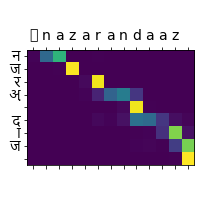

In [15]:
#@title Function to generate the attention heatmap for a transliterated roman word.
def plot_attention(attention, input_word, predicted_word, file_name):
  hindi_font = FontProperties(fname = os.path.join(os.getcwd(),"Nirmala.ttf"))
  
  fig = plt.figure(figsize=(3, 3))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')
  
  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + list(input_word), fontdict=fontdict, rotation=0)
  ax.set_yticklabels([''] + list(predicted_word), fontdict=fontdict,fontproperties=hindi_font)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.savefig(file_name)
  plt.show()

`visualize()`: Helps to visualise what the sequence to sequence model learns with the help of attention network.
#### Parameters:
**input_word**: Accepts string as input. Here we pass the transliterated roman word

**output_word**: Accepts string as input. Here we pass the predicted output word

**att_w**: Takes a list of list where each sublist denotes the attention weights learnt at a particular timestep. Each of the sublist of size equal to length of the transliterated roman word which is fed as input.

**Example:**

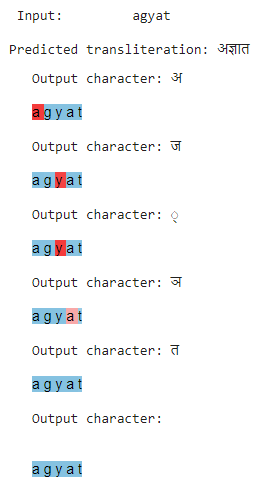


In [16]:
#@title Code to statically visualise the LSTM activations.
# get html element
def cstr(s, color='black'):
	if s == ' ':
		return "<text style=color:#000;padding-left:10px;background-color:{}> </text>".format(color, s)
	else:
		return "<text style=color:#000;background-color:{}>{} </text>".format(color, s)
	
# print html
def print_color(t):
	display(html_print(''.join([cstr(ti, color=ci) for ti,ci in t])))

# get appropriate color for value
# Darker shades of green denotes higher importance.
def get_clr(value):
	colors = ['#85c2e1', '#89c4e2', '#95cae5', '#99cce6', '#a1d0e8',
		'#b2d9ec', '#baddee', '#c2e1f0', '#eff7fb', '#f9e8e8',
		'#f9e8e8', '#f9d4d4', '#f9bdbd', '#f8a8a8', '#f68f8f',
		'#f47676', '#f45f5f', '#f34343', '#f33b3b', '#f42e2e']
	value = int((value * 100) / 5)
	return colors[value]


def visualize(input_word, output_word, att_w):
  for i in range(len(output_word)):
    print("\nOutput character:", output_word[i], "\n")
    text_colours = []
    for j in range(len(att_w[i])):
      text = (input_word[j], get_clr(att_w[i][j]))
      text_colours.append(text)
    print_color(text_colours)

`connectivity()`: Helps to visualise what the sequence to sequence model learns with the help of attention network.
#### Parameters:
**input_words**: Accepts string as input. Here we pass the transliterated roman word

**rnn_type**: Accepts string as input. Here we pass the type of RNN being used. THe acceptable values are 'RNN', 'LSTM', and 'GRU'.

**file_path**: Accepts a string as input. Here we pass the file location where we want to store the connectivity visualisation. The visualisation is stored with the file name: `connectivity.html` 

`create_file()` is used to create and store the connectivity.html file in the specified  location.

#### Parameters:
**text_colors**: List of list where each sublist denotes the color to be given to every input character on mouse hover action on an output character.

**input_words**: Accepts string as input. Here we pass the transliterated roman word.

**output_word**: Accepts string as input. Here we pass the predicted output word

**file_path**: Accepts a string as input. Here we pass the file location where we want to store the connectivity visualisation. If not specified the default file path is set to the current working directory. The visualisation is stored with the file name: `connectivity.html` 

`get_shade_color(value)`: Returns a specific colour depending the value passed to it. Here the parameter `value` Expected a floating number between 0-1 denoting the attention weight of the j<sup>th</sup> input character while predicting the i<sup>th</sup>output character.
 

In [17]:
#@title Code for connectivity visualisation.
# get appropriate color for value
# Darker shades of green denotes higher importance.
def get_shade_color(value):
	colors = ['#00fa00', '#00f500',  '#00eb00', '#00e000',  '#00db00',  
           '#00d100',  '#00c700',  '#00c200', '#00b800',  '#00ad00',  
           '#00a800',  '#009e00',  '#009400', '#008f00',  '#008500',
           '#007500',  '#007000',  '#006600', '#006100',  '#005c00',  
           '#005200',  '#004d00',  '#004700', '#003d00',  '#003800',  
           '#003300',  '#002900',  '#002400',  '#001f00',  '#001400']
	value = int((value * 100) / 5)
	return colors[value]

def create_file(text_colors,input_word,output_word,file_path=os.getcwd()):
  text = '''
  <!DOCTYPE html>
  <html>
  <head>
    <meta charset="UTF-8"> 
    <script src="https://ajax.googleapis.com/ajax/libs/jquery/3.5.1/jquery.min.js"></script>
    <script>
            $(document).ready(function(){
            var col =['''
  for k in range(3):
      for i in range(len(output_word)):
              text=text+'''['''
              for j in range(len(text_colors[k][i])-1):
                text=text+'''\"'''+text_colors[k][i][j]+'''\"'''+''','''
              text=text+'''\"'''+text_colors[k][i][len(text_colors[k][i])-1]+'''\"'''+'''],'''
  text=text[0:-1]
  text=text+'''];\n'''
  
  for k in range(3):
      for i in range(len(output_word[k])):
            text=text+'''$(\".h'''+str(k)+str(i)+'''\").mouseover(function(){\n'''
            for j in range(len(input_word[k])):
                       text=text+'''$(\".t'''+str(k)+str(j)+'''\").css(\"background-color\", col['''+str(i)+''']'''+'''['''+str(j)+''']);\n'''
            text=text+'''});\n'''
            text=text+'''$(\".h'''+str(k)+str(i)+'''\").mouseout(function(){\n'''
            for l in range(3):
              for j in range(len(input_word[l])):
                text=text+'''$(\".t'''+str(l)+str(j)+'''\").css(\"background-color\", \"#ffff99\");\n'''
            text=text+'''});\n'''
  text=text+'''});\n
</script>
  </head>
      <body>
          <h1>Connectivity:</h1>
          <p> The connection strength between the target for the selected character and the input characters is highlighted in green (reset). Hover over the text to change the selected character.</p>
          <div style="background-color:#ffff99;color:black;padding:2%; margin:4%;">
          <p>
          <div> Output: </div>
          <div style='display:flex; border: 2px solid #d0cccc; padding: 8px; margin: 8px;'>
          '''
  for k in range(3):
      for i in range(len(output_word[k])):
            text=text+'''\n'''+'''\t'''+'''<div class="h'''+str(k)+str(i)+'''\">'''+output_word[k][i]+'''</div>'''
      text=text+'''</div>'''+'\n'+'\t'+'''<div>  </p>'''+'\n'+'\t'+'''<p>
      <div> Input: </div>
      <div style='display:flex; border: 2px solid #d0cccc; padding: 8px; margin: 8px;'>'''    
      for j in range(len(input_word[k])):
        text=text+'''\n'''+'''\t'''+'''<div class="t'''+str(k)+str(j)+'''\">'''+input_word[k][j]+'''</div>'''
      if k<2:
          text = text+'''</div></p></div><p></p></div>
          <div style="background-color:#ffff99;color:black;padding:2%; margin:4%;">
          <div> Output: </div>
          <div style='display:flex; border: 2px solid #d0cccc; padding: 8px; margin: 8px;'>'''
  text=text+'''
        </div>
        </p>
        </div>
        </body>
  </html>
  '''
  fname = os.path.join(file_path,"connectivity.html")
  file = open(fname,"w")
  file.write(text)
  file.close()

def connectivity(input_words,rnn_type,file_path):
  color_list=[]
  input_word_list=[]
  output_word_list=[]
  for k in range(3):
    output_word, input_word, _ ,att_w = inference_model(input_words[k],rnn_type)
    text_colours=[]
    for i in range(len(output_word)):
      colour=[]
      for j in range(len(att_w[i])):
        value=get_shade_color(att_w[i][j])
        colour.append(value)
      text_colours.append(colour)
    color_list.append(text_colours)
    input_word_list.append(input_word)
    output_word_list.append(output_word)
  create_file(color_list,input_word_list,output_word_list,file_path)

`transliterate()`: Finds the predicted target word for a given tansliterated roman word, plots the attention heatmap and visualises the LSTM activations if the visual_flag is set to True.
#### Parameters:
input_word:Accepts string as input. Here we pass the transliterated roman word</br>
**rnn_type**: Accepts string as input. Here we pass the type of RNN being used. THe acceptable values are 'RNN', 'LSTM', and 'GRU'.</br>
**file_path**: Accepts a string as input. Here we pass the file location where we want to store the attention heatmap for the input word and the predicted target word. If not specified the attention heatmaps is stored in the current working directory by the name "attention_heatmap.png"</br>
**visual_flag**: Accepts a boolean True or boolean False. If the visual_flag is set to true then the code to statically visualise the LSTM activations are called. Default value of the flag is set to "True".

In [18]:
#@title Code to get the predicted target word from a transliterated roman word.
def transliterate(input_word,rnn_type,file_name=os.path.join(os.getcwd(),"attention_heatmap.png"),visual_flag=True):
  predicted_word, input_word, attention_plot,att_w = inference_model(input_word,rnn_type)

  print("\n",'Input:', input_word)
  print('Predicted transliteration:', predicted_word)

  attention_plot = attention_plot[:len(predicted_word),
                                  :len(input_word)]
  plot_attention(attention_plot, input_word, predicted_word, file_name)

  if visual_flag == True:
    visualize(input_word, predicted_word, att_w)

`generate_inputs()`: Randomly chooses 10 inputs from the test dataset and calles the transliteration() to produce the predicted target input and heatmaps. It also set the visual_flag in transliteration() to True only for the first test input and False for the rest 9 test inputs.
####Parameters:
**rnn_type**: Accepts string as input. Here we pass the type of RNN being used. THe acceptable values are 'RNN', 'LSTM', and 'GRU'.</br>
**n_test_samples**: Accepts an integer as input. Here we pass number of test inputs to be used for the heatmap generation. Default value is set to 10.

In [19]:
#@title Code to randomly choose 10 test inputs for attention heatmap generation.
def generate_inputs(rnn_type,n_test_samples=10):
  target_words, input_words = create_dataset(test_file_path)
  
  for i in range (n_test_samples):
    index = random.randint(0,len(input_words))
    input_word=input_words[index]
    file_name=os.path.join(os.getcwd(),"predictions_attention",str(run_name),input_word+".png")
    
    if i == 0:
      transliterate(input_word[1:-1],rnn_type, file_name,True)
    elif i > 0:
      transliterate(input_word[1:-1],rnn_type, file_name,False)

Uncomment wandb.agent() to use wandb and comment the call to train().

In [ ]:
#wandb.agent("utsavdey/attention-seq-to-seq/w8pglu2i",train)
train(use_wandb=False)

In [ ]:
#@title Download a copy of the predictions_attention and training_checkpoints folder.
!zip -r /content/predictions_attention.zip /content/predictions_attention
!zip -r /content/training_checkpoints.zip /content/training_checkpoints
from google.colab import files
files.download("/content/predictions_attention.zip")
files.download("/content/training_checkpoints.zip")